In [7]:
from typing import Sequence, Union
from jaxtyping import Float
from discretize import TensorMesh
import numpy as np
from numpy.fft import fftfreq, fftshift
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg
from scipy.integrate import romb

In [45]:
x_domain = (-24, 24)
num_samples = 2**3 + 1
x = np.linspace(*x_domain, num_samples)
dx = x[1] - x[0]

k = fftfreq(num_samples, dx)
dk = k[1] - k[0]
reciprocal_space_mesh = TensorMesh([2*np.pi*dk*np.ones(num_samples)], origin='C')
#Check dims
#assert np.allclose(fftshift(k), reciprocal_space_mesh.cell_centers_x)
#assert np.allclose(k, ifftshift(reciprocal_space_mesh.cell_centers_x))

grad_k = reciprocal_space_mesh.average_face_x_to_cell.dot(reciprocal_space_mesh.cell_gradient_x)
lap_k = reciprocal_space_mesh.face_x_divergence.dot(reciprocal_space_mesh.cell_gradient_x)

In [72]:
def n_th_derivative(n: int) -> scipy.sparse.spmatrix:
    if n == 0:
        return scipy.sparse.identity(num_samples)
    elif n % 2 == 0:
        k = (n//2) - 1
        D = lap_k.copy()
        for _ in range(k):
            D = D.dot(lap_k)
        return D
    else:
        k = (n - 1)//2
        D = grad_k.copy()
        for _ in range(k):
            D = D.dot(lap_k)
        return D

In [73]:
def FP_operator(
        potential_poly: np.polynomial.Polynomial, 
        momentum_sample: Float[np.ndarray, 'k'], 
        gamma: float,
        noise_intensity: float, 
        alpha: Union[float, int] = 2
    ) -> scipy.sparse.spmatrix:
    force_coeffs = -1.0*(potential_poly.deriv().coef)
    phases = np.power(-1j, -np.arange(len(force_coeffs), dtype=int))
    coeffs = phases*force_coeffs*(gamma**-1)
    
    L = -1.0*noise_intensity*scipy.sparse.diags(np.abs(momentum_sample)**alpha)
    
    diag_k = 1j*scipy.sparse.diags(momentum_sample)
    for i, c in enumerate(coeffs):
        L -= c*diag_k.dot(n_th_derivative(i))
    return L

### Example, bistable potential

In [74]:
def bistable_potential(width=1.0, depth=1.0):
   h = 4*depth/(width**2)
   g = 4*depth/(width**4)
   p =  np.polynomial.Polynomial([0.0, 0.0, -0.5*h, 0.0, 0.25*g])
   return p

def harmonic_potential(width):
   p =  np.polynomial.Polynomial([0.0, 0.0, 0.5*width])
   return p

def quartic_potential(width):
   p =  np.polynomial.Polynomial([0.0, 0.0, 0.0, 0.0, 0.25*width])
   return p

In [75]:
depth = 2.0
width = 1.5
bistable_poly = bistable_potential(width, depth)

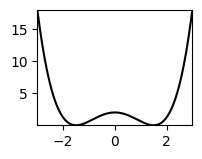

In [76]:
fig, ax = plt.subplots(figsize=(2, 1.5))
x_sample = np.linspace(-width*2, width*2, 200)
ax.plot(x_sample, bistable_poly(x_sample) + depth, 'k-')
ax.margins(0)

In [77]:
momentum_sample = reciprocal_space_mesh.cell_centers
gamma = 0.1
noise_intensity = width
kbT = noise_intensity*gamma*0.5
print(f'kbT = {kbT}')
L = FP_operator(bistable_poly, momentum_sample, gamma, noise_intensity, alpha=2).toarray()

kbT = 0.07500000000000001


In [102]:
vals, _lvecs, _rvecs = scipy.linalg.eig(L, left=True, right=True)
sort_perm = np.flip(np.argsort(vals.real))
vals = vals[sort_perm]
_lvecs = _lvecs[:, sort_perm]
_rvecs = _rvecs[:, sort_perm]

In [104]:
vals

array([ 1.02101142e+05+3.56525107e+07j,  1.02101142e+05+3.56525107e+07j,
        1.02101142e+05-3.56525107e+07j, ...,
       -5.01269879e+02+1.28350583e-12j, -1.32503289e+08+0.00000000e+00j,
       -1.32503289e+08-3.72529030e-09j])

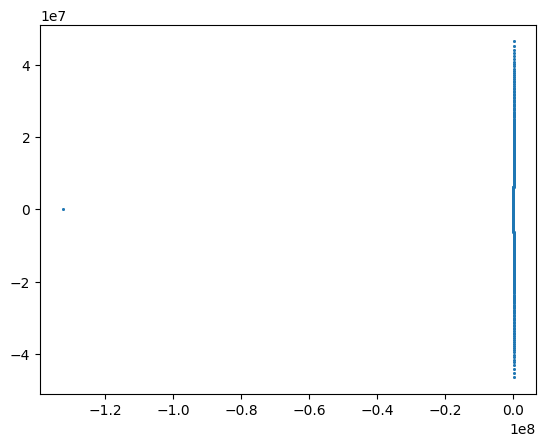

In [103]:
plt.scatter(vals.real, vals.imag, s=1)

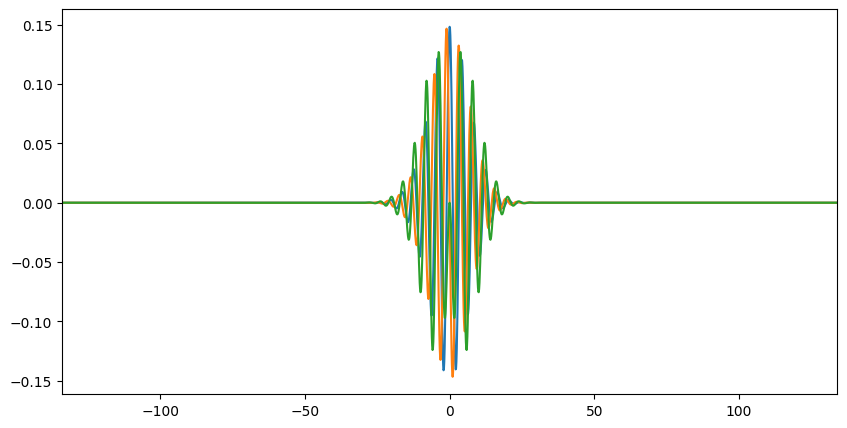

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(3):
    ax.plot(reciprocal_space_mesh.cell_centers, _rvecs[:, i].real, label=f'{i}')
ax.margins(x=0)

In [174]:
def inverse_fourier_transform(f, k, x):
    phase = np.exp(1j*x[:, None]*k[None, :]) #(x, k)
    f_phase = phase[..., None]*f[None, ...] #(x, k, f)
    return romb(f_phase, dx=k[1] - k[0], axis=1)
def standardize_evecs(levecs, revecs):
    _levecs = np.zeros_like(levecs)
    _revecs = np.zeros_like(revecs)
    eps = 1e-10
    for i in range(levecs.shape[1]):
        _L_real_part = np.max(np.abs(levecs[:, i].real))
        _R_real_part = np.max(np.abs(revecs[:, i].real))
        if (_L_real_part < eps) and (_R_real_part < eps):
            _levecs[:, i] = levecs[:, i]*1j
            _revecs[:, i] = revecs[:, i]/1j
        else:
            _levecs[:, i] = levecs[:, i]
            _revecs[:, i] = revecs[:, i]
    return _levecs, _revecs

In [82]:
lvecs = inverse_fourier_transform(_lvecs, reciprocal_space_mesh.cell_centers, x_sample)
rvecs = inverse_fourier_transform(_rvecs, reciprocal_space_mesh.cell_centers, x_sample)
lvecs, rvecs = standardize_evecs(lvecs, rvecs)

In [83]:
lvecs.shape

(200, 2049)

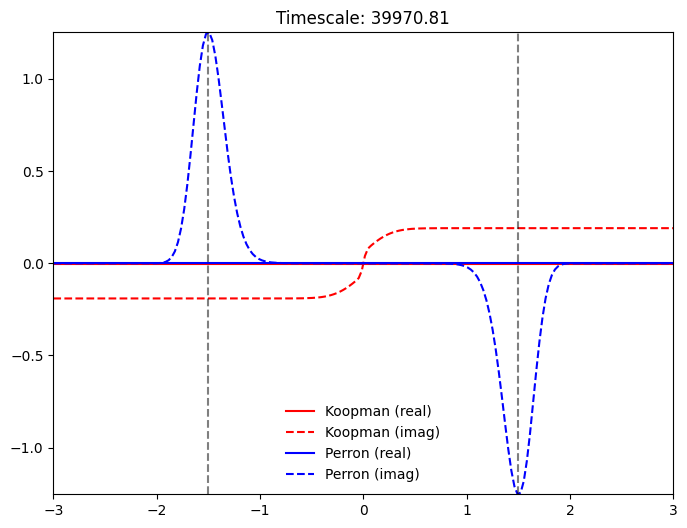

In [87]:
fun_idx = 1

lfn = lvecs[:, fun_idx]
rfn = rvecs[:, fun_idx]

fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x_sample, poly_potential(x_sample, bistable_coefficients), 'k-')
ax.plot(x_sample, lfn.real, 'r-', ms=1.0, label='Koopman (real)')
ax.plot(x_sample, lfn.imag, 'r--', label='Koopman (imag)')
ax.plot(x_sample, rfn.real, 'b-', ms=0.1, label='Perron (real)')
ax.plot(x_sample, rfn.imag, 'b--', label='Perron (imag)')
ax.axvline(-width, color='k', ls='--', alpha=0.5)
ax.axvline(width, color='k', ls='--', alpha=0.5)
ax.set_title(f"Timescale: {-(vals[fun_idx].real)**-1:.2f}")
ax.legend(frameon=False)
ax.margins(0)


### New version using the `findiff` package
In 1D, the Fokker Planck operator for the symmetric-$\alpha$-stable driven Langevin equation reads:
$$ (\mathcal{L}u)(x) = \frac{1}{\gamma m} \frac{\partial}{\partial x}\left[u(x)\frac{\partial}{\partial x}V(x)\right] + D \frac{\partial^{\alpha}}{\partial x^{\alpha}}u(x)$$
 
Fourier-transforming and with the assumption that $V(x) := \sum_{n = 1}^{p}\frac{t_{n}}{n}x^{n}$,

$$(\mathcal{L}u)(k) = \sum_{n=1}^{p} \frac{t_{n}}{(-i)^{n}}k\frac{\partial^{n-1}}{\partial k^{n-1}}u(k) - D |k|^{\alpha}u(k)$$

In [111]:
from findiff import FinDiff, Coefficient, Identity

In [197]:
x_domain = (-15, 15)
num_samples = 2**11 + 1
x = np.linspace(*x_domain, num_samples)
dx = x[1] - x[0]

k = fftfreq(num_samples, dx)
dk = k[1] - k[0]
k = fftshift(k)

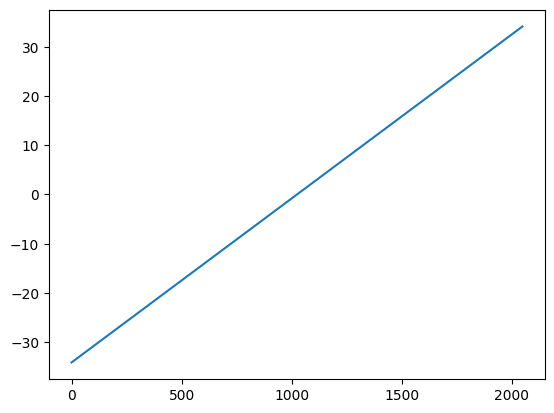

In [198]:
plt.plot(k)

In [199]:
def n_th_derivative(n, dx):
    if n == 0:
        return Identity()
    else:
        return FinDiff(0, dx, n)

In [200]:
def fokker_planck(k, dk, potential_coeffs, gamma, noise_intensity, alpha=2):
    phases = np.power(-1j, -np.arange(len(potential_coeffs), dtype=int) + 1)
    coeffs = phases*potential_coeffs*(gamma**-1)
    
    L = -1.0*noise_intensity*scipy.sparse.diags(np.abs(k)**alpha)
    
    _findiff_op = Coefficient(k*coeffs[0])*n_th_derivative(0, dk)
    for i, c in enumerate(coeffs):
        if i > 0:
            _findiff_op = _findiff_op + Coefficient(c*k)*n_th_derivative(i, dk)
    L += _findiff_op.matrix(k.shape)
    return L.toarray()

In [201]:
depth = 2.0
width = 1.5
h = 4*depth/(width**2)
g = 4*depth/(width**4)

gamma = 0.1
noise_intensity = width

bistable_coeffs = np.array([0, -h, 0, g])

In [202]:
L = fokker_planck(k, dk, bistable_coeffs, gamma, noise_intensity, alpha=2)

In [203]:
_vals, _lvecs, _rvecs = scipy.linalg.eig(L, left=True, right=True)

In [204]:
vals = _vals[_vals.real <= 0]
lvecs = _lvecs[:, _vals.real <= 0]
rvecs = _rvecs[:, _vals.real <= 0]

sort_perm = np.flip(np.argsort(vals.real))
vals = vals[sort_perm]
lvecs = lvecs[:, sort_perm]
rvecs = rvecs[:, sort_perm]

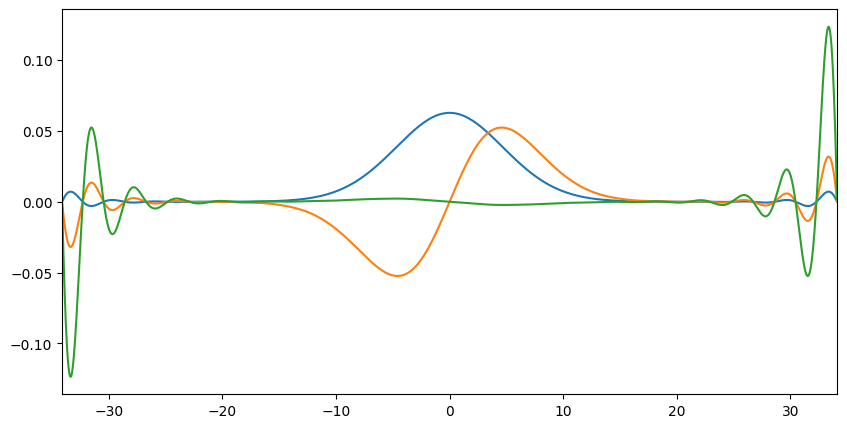

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(3):
    ax.plot(k, rvecs[:, i].real, label=f'{i}')
ax.margins(x=0)

In [206]:
x_sample = np.linspace(-width*2, width*2, 200)
lvecs = inverse_fourier_transform(lvecs, k, x_sample)
rvecs = inverse_fourier_transform(rvecs, k, x_sample)
lvecs, rvecs = standardize_evecs(lvecs, rvecs)

/tmp/ipykernel_164439/3969226700.py:14: RuntimeWarning: divide by zero encountered in scalar power
  ax.set_title(f"Timescale: {-(vals[fun_idx].real)**-1:.2f}")


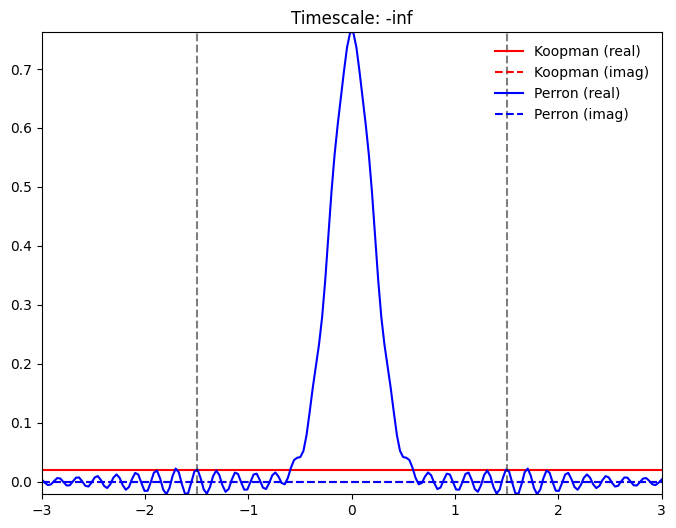

In [210]:
fun_idx = 0

lfn = lvecs[:, fun_idx]
rfn = rvecs[:, fun_idx]

fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x_sample, poly_potential(x_sample, bistable_coefficients), 'k-')
ax.plot(x_sample, lfn.real, 'r-', ms=1.0, label='Koopman (real)')
ax.plot(x_sample, lfn.imag, 'r--', label='Koopman (imag)')
ax.plot(x_sample, rfn.real, 'b-', ms=0.1, label='Perron (real)')
ax.plot(x_sample, rfn.imag, 'b--', label='Perron (imag)')
ax.axvline(-width, color='k', ls='--', alpha=0.5)
ax.axvline(width, color='k', ls='--', alpha=0.5)
ax.set_title(f"Timescale: {-(vals[fun_idx].real)**-1:.2f}")
ax.legend(frameon=False)
ax.margins(0)
